## Target SiteEnergyUseWN(kBtu)

SiteEnergyUseWN(kBtu) - The annual amount of energy consumed by the property from all sources of energy, adjusted to what the property would have consumed during 30-year average weather conditions (one thousand British Thermal Units)

1 kilowatt hour has 3.41 kiloBTU)

In [1]:
# Importation des librairies


import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import numpy as np
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec 
import statsmodels as stat
from statsmodels.tsa.api import Holt
from statsmodels.tools.sm_exceptions import ConvergenceWarning
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer

In [2]:
data = pd.read_csv("data_cleaned_P4.csv", sep=",")

In [3]:
data = data.drop(['Unnamed: 0'], axis=1)

**The usage of gas/electricity/steam**

In [4]:
# la nouvelle variable 'Electricity_using', prend la valeur 1 si la propriété utilise l'électricité et 0 si ce n'est pas le cas
data['Electricity_using'] = np.where(data['Electricity(kBtu)'] > 0, 1, 0)

In [5]:
# la nouvelle variable 'Natural_gas_using', prend la valeur 1 si la propriété utilise l'électricité et 0 si ce n'est pas le cas
data['Natural_gas_using'] = np.where(data['NaturalGas(kBtu)'] > 0, 1, 0)

In [6]:
# la nouvelle variable 'Steam_using', prend la valeur 1 si la propriété utilise l'électricité et 0 si ce n'est pas le cas
data['Steam_using'] = np.where(data['SteamUse(kBtu)'] > 0, 1, 0)

**Variables qualitative**

In [7]:
# Les colonnes object dtypes sont séléctionnés
obj_columns = list(data.select_dtypes(include=['object', 'bool']).columns)

print("Les variables qualitatives sont les suivantes : \n")
for categ in obj_columns :
    print(categ, ":", data[categ].nunique())

Les variables qualitatives sont les suivantes : 

BuildingType : 3
PrimaryPropertyType : 21
Neighborhood : 19
LargestPropertyUseType : 55
SecondLargestPropertyUseType : 48
ThirdLargestPropertyUseType : 39


**Variables quantitatives**

In [8]:
# Les colonnes float64 et int64 sont séléctionnés
num_columns = list(data.select_dtypes(include=['float64', 'int64']).columns)
print("Les variables quantitatives sont les suivantes : \n")
for num in num_columns :
    print(num)

Les variables quantitatives sont les suivantes : 

Latitude
Longitude
NumberofBuildings
NumberofFloors
PropertyGFATotal
LargestPropertyUseTypeGFA
SecondLargestPropertyUseTypeGFA
ThirdLargestPropertyUseTypeGFA
ENERGYSTARScore
SiteEUI(kBtu/sf)
SiteEUIWN(kBtu/sf)
SourceEUI(kBtu/sf)
SiteEnergyUse(kBtu)
SiteEnergyUseWN(kBtu)
SteamUse(kBtu)
Electricity(kBtu)
NaturalGas(kBtu)
TotalGHGEmissions
GHGEmissionsIntensity
building_age
NonResidential
Nonresidential COS
Nonresidential WA
contain_parking
parking_area_rate
Office_largest_area_rate
Non_Refrigerated_Warehouse_largest_area_rate
Retail_Store_area_rate
Other_largest_area_rate
Hotel_largest_area_rate
Worship_Facility_largest_area_rate
Distribution_Center_largest_area_rate
Medical_Office_largest_area_rate
Supermarket_largest_area_rate
K_12_School_largest_area_rate
Recreation_largest_area_rate
Office_second_largest_area_rate
Retail_Store_second_largest_area_rate
Other_second_largest_area_rate
Restaurant_second_largest_area_rate
Non_Refrigerated

## Random forest algorithm

Auparavant, nous avons utilisé One-Hot Encoding pour convertir toutes les variables catégorielles en numériques.

Étant donné que les algorithmes de machine learning habituels ne fonctionnent que sur des variables quantitatives.

In [9]:
# Afin de préparer les données pour la modélisation nous allons éliminer les variables catégorielles
data = data.drop(['BuildingType'], axis=1)
data = data.drop(['PrimaryPropertyType'], axis=1)
data = data.drop(['Neighborhood'], axis=1)
data = data.drop(['LargestPropertyUseType'], axis=1)
data = data.drop(['SecondLargestPropertyUseType'], axis=1)
data = data.drop(['ThirdLargestPropertyUseType'], axis=1)

In [10]:
# SiteEnergyUseWN(kBtu) sont les valeurs que nous voulons prédire
SiteEnergyUseWN = np.array(data['SiteEnergyUseWN(kBtu)'])

In [11]:
# Eliminer SiteEnergyUseWN(kBtu) de data
data_to_model_energy = data.drop(['SiteEnergyUseWN(kBtu)', 'SiteEnergyUse(kBtu)', 'NaturalGas(kBtu)', 'Electricity(kBtu)', 'SteamUse(kBtu)', 'SiteEUI(kBtu/sf)', 'SiteEUIWN(kBtu/sf)', 'SourceEUI(kBtu/sf)', 'TotalGHGEmissions', 'GHGEmissionsIntensity'], axis = 1)

In [12]:
# Enregistrement des noms de colonnes pour une utilisation ultérieure
data_to_model_energy_list = list(data_to_model_energy.columns)

In [13]:
# Convertir en numpy array
data_to_model_energy = np.array(data_to_model_energy)

**Training and Testing Sets**

In [14]:
# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split

In [15]:
# Split the data into training and testing sets
train_data_to_model_energy, test_data_to_model_energy, train_SiteEnergyUseWN, test_SiteEnergyUseWN = train_test_split(data_to_model_energy, SiteEnergyUseWN, test_size = 0.25, random_state = 42)

Nous pouvons examiner la forme de toutes les données pour nous assurer que nous avons tout fait correctement.

In [16]:
print('Training data_to_model_energy Shape:', train_data_to_model_energy.shape)
print('Training SiteEnergyUseWN Shape:', train_SiteEnergyUseWN.shape)
print('Testing data_to_model_energy Shape:', test_data_to_model_energy.shape)
print('Testing SiteEnergyUseWN Shape:', test_SiteEnergyUseWN.shape)

Training data_to_model_energy Shape: (1131, 132)
Training SiteEnergyUseWN Shape: (1131,)
Testing data_to_model_energy Shape: (377, 132)
Testing SiteEnergyUseWN Shape: (377,)


Il semble que tout soit en ordre

**Train Model**

In [17]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor

In [18]:
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)

In [19]:
# Train the model on training data
rf.fit(train_data_to_model_energy, train_SiteEnergyUseWN)

RandomForestRegressor(n_estimators=1000, random_state=42)

**Make Predictions on the Test Set**

In [20]:
# Use the forest's predict method on the test data
predictions = rf.predict(test_data_to_model_energy)

**Evaluation of the model R^2**

In [21]:
from sklearn.metrics import r2_score
test_score = r2_score(test_SiteEnergyUseWN, predictions)

print('R-squared scores:', round(test_score, 5))

R-squared scores: 0.38442


In [22]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error


# Mean absolute error (MAE)
mae = mean_absolute_error(test_SiteEnergyUseWN, predictions)
mape = mean_absolute_percentage_error(test_SiteEnergyUseWN, predictions)

print('Mean Absolute Error:', round(mae, 2))
print('Mean Absolute Percentage Error:', round(mape, 2))

Mean Absolute Error: 4047245.21
Mean Absolute Percentage Error: 2.3518694830233105e+20


On peut améliorer la performanve du modele - tuning des hyperparameters

**Tuning the parameters**

In [23]:
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
print(rf.get_params())

Parameters currently in use:

{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'mse', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 1000, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}


In [24]:
# Import GridSearchCV
from sklearn.model_selection import GridSearchCV

# Find the best parameters for the model
parameters = {
 'bootstrap': [True, False],
 'max_depth': [4, 5, 6, 7, 8, 10, 15, 20, 25, 30, None],
 'max_features': ['auto', 'sqrt'],
 #'min_samples_leaf': [1, 2, 4],
 #'min_samples_split': [2, 5, 10],
 'n_estimators': [600, 800, 1000, 1200, 1400]
}

gridforest = GridSearchCV(rf, parameters, cv = 3, n_jobs = -1, verbose = 1)
gridforest.fit(train_data_to_model_energy, train_SiteEnergyUseWN)
gridforest.best_params_

Fitting 3 folds for each of 220 candidates, totalling 660 fits


{'bootstrap': True,
 'max_depth': 20,
 'max_features': 'sqrt',
 'n_estimators': 800}

Si l'on passe les paramètres obtenus à l'algorithme, on verra que les erreurs ont diminué et que les scores R au carré ont augmenté, ce qui signifie que l'algorithme avec les hyperparamètres réglés a une précision de prédiction plus élevée.

In [25]:
# Instantiate model with 1000 decision trees
rf_tuned = RandomForestRegressor(n_estimators = 800, max_depth = 20, max_features = 'sqrt', bootstrap = True, random_state = 42)

In [26]:
# Train the model on training data
rf_tuned.fit(train_data_to_model_energy, train_SiteEnergyUseWN)

RandomForestRegressor(max_depth=20, max_features='sqrt', n_estimators=800,
                      random_state=42)

In [27]:
# Use the forest's predict method on the test data
predictions_tuned= rf_tuned.predict(test_data_to_model_energy)

In [28]:
test_score = r2_score(test_SiteEnergyUseWN, predictions_tuned)

print('R-squared scores:', round(test_score, 5))

R-squared scores: 0.46861


In [30]:
# Mean absolute error (MAE)
mae = mean_absolute_error(test_SiteEnergyUseWN, predictions_tuned)

print('Mean Absolute Error:', round(mae, 2))

Mean Absolute Error: 4075090.04


Lorsque les hyperparamètres sont ajustés, les performances du modèle sont améliorées

## Ridge Regression

In [39]:
import pandas as pd
import numpy as np
from sklearn import model_selection
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt

In [31]:
# SiteEnergyUseWN(kBtu) sont les valeurs que nous voulons prédire
SiteEnergyUseWN = np.array(data['SiteEnergyUseWN(kBtu)'])

In [32]:
# Eliminer SiteEnergyUseWN(kBtu) de data
data_to_model_energy = data.drop(['SiteEnergyUseWN(kBtu)', 'SiteEnergyUse(kBtu)', 'NaturalGas(kBtu)', 'Electricity(kBtu)', 'SteamUse(kBtu)', 'SiteEUI(kBtu/sf)', 'SiteEUIWN(kBtu/sf)', 'SourceEUI(kBtu/sf)', 'TotalGHGEmissions', 'GHGEmissionsIntensity'], axis = 1)

In [33]:
# Enregistrement des noms de colonnes pour une utilisation ultérieure
data_to_model_energy_list = list(data_to_model_energy.columns)

In [34]:
# Convertir en numpy array
data_to_model_energy = np.array(data_to_model_energy)

In [35]:
# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split

In [36]:
# Split the data into training and testing sets
train_data_to_model_energy, test_data_to_model_energy, train_SiteEnergyUseWN, test_SiteEnergyUseWN = train_test_split(data_to_model_energy, SiteEnergyUseWN, test_size = 0.25, random_state = 42)

In [40]:
print('Training data_to_model_energy Shape:', train_data_to_model_energy.shape)
print('Training SiteEnergyUseWN Shape:', train_SiteEnergyUseWN.shape)
print('Testing data_to_model_energy Shape:', test_data_to_model_energy.shape)
print('Testing SiteEnergyUseWN Shape:', test_SiteEnergyUseWN.shape)

Training data_to_model_energy Shape: (1131, 132)
Training SiteEnergyUseWN Shape: (1131,)
Testing data_to_model_energy Shape: (377, 132)
Testing SiteEnergyUseWN Shape: (377,)


In [41]:
# Instantiate model with regularization coeficient alpha = 0.01
rr = Ridge(alpha=0.01)

In [42]:
# Train the model on the X training set and target (Y) training set
rr.fit(train_data_to_model_energy, train_SiteEnergyUseWN) 

Ridge(alpha=0.01)

In [43]:
# Calculate predicted values using the trained model
pred_train_rr= rr.predict(train_data_to_model_energy)

In [44]:
# Evaluate the model on the training set
print(np.sqrt(mean_squared_error(train_SiteEnergyUseWN,pred_train_rr)))
print(r2_score(train_SiteEnergyUseWN, pred_train_rr))

7549693.723442148
0.8322247882257374


In [45]:
# Evaluate the model on the test set
pred_test_rr= rr.predict(test_data_to_model_energy)
print(np.sqrt(mean_squared_error(test_SiteEnergyUseWN,pred_test_rr))) 
print(r2_score(test_SiteEnergyUseWN, pred_test_rr))

16762585.416418089
0.33162075630611876


In [46]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error


# Mean absolute error (MAE)
mae = mean_absolute_error(test_SiteEnergyUseWN, pred_test_rr)
mape = mean_absolute_percentage_error(test_SiteEnergyUseWN, pred_test_rr)

print('Mean Absolute Error:', round(mae, 2))
print('Mean Absolute Percentage Error:', round(mape, 2))

Mean Absolute Error: 5443591.22
Mean Absolute Percentage Error: 1.5546205656081007e+20


On peut essayer d'améliorer le modèle en ajustant alpha

**Tuning des parameters**

In [47]:
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
print(rr.get_params())

Parameters currently in use:

{'alpha': 0.01, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'normalize': False, 'random_state': None, 'solver': 'auto', 'tol': 0.001}


In [48]:
# Import GridSearchCV
from sklearn.model_selection import GridSearchCV

# Find the best parameters for the model
parameters = {
 'alpha': [0.01, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
}

ridge = GridSearchCV(rr, parameters, cv = 3, n_jobs = -1, verbose = 1)
ridge.fit(train_data_to_model_energy, train_SiteEnergyUseWN)
ridge.best_params_

Fitting 3 folds for each of 13 candidates, totalling 39 fits


{'alpha': 1.0}

In [49]:
# Instantiate model with regularization coeficient alpha = 1.0
rr_tuned = Ridge(alpha=1.0)

In [50]:
# Train the model on the X training set and target (Y) training set
rr_tuned.fit(train_data_to_model_energy, train_SiteEnergyUseWN) 

Ridge()

In [51]:
# Calculate predicted values using the trained model
pred_train_rr_tuned= rr_tuned.predict(train_data_to_model_energy)

In [52]:
# Evaluate the model on the training set
print(np.sqrt(mean_squared_error(train_SiteEnergyUseWN,pred_train_rr_tuned)))
print(r2_score(train_SiteEnergyUseWN, pred_train_rr_tuned))

7709216.286714446
0.8250598118977028


In [53]:
# Evaluate the model on the test set
pred_test_rr_tuned= rr_tuned.predict(test_data_to_model_energy)
print(np.sqrt(mean_squared_error(test_SiteEnergyUseWN,pred_test_rr_tuned))) 
print(r2_score(test_SiteEnergyUseWN, pred_test_rr_tuned))

16648027.762202494
0.34072511804684646


In [54]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error


# Mean absolute error (MAE)
mae = mean_absolute_error(test_SiteEnergyUseWN, pred_test_rr_tuned)
mape = mean_absolute_percentage_error(test_SiteEnergyUseWN, pred_test_rr_tuned)

print('Mean Absolute Error:', round(mae, 2))
print('Mean Absolute Percentage Error:', round(mape, 2))

Mean Absolute Error: 5344172.52
Mean Absolute Percentage Error: 1.6588460370469434e+20


On peut remarquer une légère amélioration des performances du modèle

## Lasso Regression

Comme les algorithmes Ridge et Lasso sont similaires, on s'attend à ce qu'ils affichent des performances similaires

In [55]:
# SiteEnergyUseWN(kBtu) sont les valeurs que nous voulons prédire
SiteEnergyUseWN = np.array(data['SiteEnergyUseWN(kBtu)'])

In [56]:
# Eliminer SiteEnergyUseWN(kBtu) de data
data_to_model_energy = data.drop(['SiteEnergyUseWN(kBtu)', 'SiteEnergyUse(kBtu)', 'NaturalGas(kBtu)', 'Electricity(kBtu)', 'SteamUse(kBtu)', 'SiteEUI(kBtu/sf)', 'SiteEUIWN(kBtu/sf)', 'SourceEUI(kBtu/sf)', 'TotalGHGEmissions', 'GHGEmissionsIntensity'], axis = 1)

In [57]:
# Enregistrement des noms de colonnes pour une utilisation ultérieure
data_to_model_energy_list = list(data_to_model_energy.columns)

In [58]:
# Convertir en numpy array
data_to_model_energy = np.array(data_to_model_energy)

In [59]:
# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split

In [60]:
# Split the data into training and testing sets
train_data_to_model_energy, test_data_to_model_energy, train_SiteEnergyUseWN, test_SiteEnergyUseWN = train_test_split(data_to_model_energy, SiteEnergyUseWN, test_size = 0.25, random_state = 42)

In [61]:
print('Training data_to_model_energy Shape:', train_data_to_model_energy.shape)
print('Training SiteEnergyUseWN Shape:', train_SiteEnergyUseWN.shape)
print('Testing data_to_model_energy Shape:', test_data_to_model_energy.shape)
print('Testing SiteEnergyUseWN Shape:', test_SiteEnergyUseWN.shape)

Training data_to_model_energy Shape: (1131, 132)
Training SiteEnergyUseWN Shape: (1131,)
Testing data_to_model_energy Shape: (377, 132)
Testing SiteEnergyUseWN Shape: (377,)


In [62]:
# Lasso model with alpha = 0.01
model_lasso = Lasso(alpha=0.01)

In [63]:
# Train the model on the training set
model_lasso.fit(train_data_to_model_energy, train_SiteEnergyUseWN) 

C:\Openclassrooms\P2\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.2230149822968604e+16, tolerance: 38423195120830.31
  model = cd_fast.enet_coordinate_descent(


Lasso(alpha=0.01)

In [64]:
# Predictions on the training set
pred_train_lasso= model_lasso.predict(train_data_to_model_energy)

In [65]:
# Evaluating the performance of the model on the training set
print(np.sqrt(mean_squared_error(train_SiteEnergyUseWN,pred_train_lasso)))
print(r2_score(train_SiteEnergyUseWN, pred_train_lasso))

7549443.051966594
0.8322359292768158


In [66]:
# Prediction on the test set
pred_test_lasso= model_lasso.predict(test_data_to_model_energy)

In [67]:
# Evaluating the model on the test set
print(np.sqrt(mean_squared_error(test_SiteEnergyUseWN,pred_test_lasso))) 
print(r2_score(test_SiteEnergyUseWN, pred_test_lasso))

16763063.928222898
0.33158259609214047


Cette valeur de R^2 est proche de celle montrée par l'algorithme Ridge

In [68]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error


# Mean absolute error (MAE)
mae = mean_absolute_error(test_SiteEnergyUseWN, pred_test_lasso)
mape = mean_absolute_percentage_error(test_SiteEnergyUseWN, pred_test_lasso)

print('Mean Absolute Error:', round(mae, 2))
print('Mean Absolute Percentage Error:', round(mape, 2))

Mean Absolute Error: 5449992.82
Mean Absolute Percentage Error: 1.55207329148654e+20


**Tuning des parameters**

In [69]:
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
print(model_lasso.get_params())

Parameters currently in use:

{'alpha': 0.01, 'copy_X': True, 'fit_intercept': True, 'max_iter': 1000, 'normalize': False, 'positive': False, 'precompute': False, 'random_state': None, 'selection': 'cyclic', 'tol': 0.0001, 'warm_start': False}


In [70]:
# Import GridSearchCV
from sklearn.model_selection import GridSearchCV

# Find the best parameters for the model
parameters = {
 'alpha': [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
}

lasso = GridSearchCV(model_lasso, parameters, cv = 3, n_jobs = -1, verbose = 1)
lasso.fit(train_data_to_model_energy, train_SiteEnergyUseWN)
lasso.best_params_

Fitting 3 folds for each of 19 candidates, totalling 57 fits


C:\Openclassrooms\P2\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.2230149822968604e+16, tolerance: 38423195120830.31
  model = cd_fast.enet_coordinate_descent(


{'alpha': 0.01}

alpha = 0.01 est le meilleur choix

## XGBoost regression

In [71]:
# SiteEnergyUseWN(kBtu) sont les valeurs que nous voulons prédire
SiteEnergyUseWN = np.array(data['SiteEnergyUseWN(kBtu)'])

In [72]:
# Eliminer SiteEnergyUseWN(kBtu) de data
data_to_model_energy = data.drop(['SiteEnergyUseWN(kBtu)', 'SiteEnergyUse(kBtu)', 'NaturalGas(kBtu)', 'Electricity(kBtu)', 'SteamUse(kBtu)', 'SiteEUI(kBtu/sf)', 'SiteEUIWN(kBtu/sf)', 'SourceEUI(kBtu/sf)', 'TotalGHGEmissions', 'GHGEmissionsIntensity'], axis = 1)

In [73]:
# Enregistrement des noms de colonnes pour une utilisation ultérieure
data_to_model_energy_list = list(data_to_model_energy.columns)

In [74]:
# Convertir en numpy array
data_to_model_energy = np.array(data_to_model_energy)

In [75]:
# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split

In [76]:
# Split the data into training and testing sets
train_data_to_model_energy, test_data_to_model_energy, train_SiteEnergyUseWN, test_SiteEnergyUseWN = train_test_split(data_to_model_energy, SiteEnergyUseWN, test_size = 0.25, random_state = 0)

In [77]:
print('Training data_to_model_energy Shape:', train_data_to_model_energy.shape)
print('Training SiteEnergyUseWN Shape:', train_SiteEnergyUseWN.shape)
print('Testing data_to_model_energy Shape:', test_data_to_model_energy.shape)
print('Testing SiteEnergyUseWN Shape:', test_SiteEnergyUseWN.shape)

Training data_to_model_energy Shape: (1131, 132)
Training SiteEnergyUseWN Shape: (1131,)
Testing data_to_model_energy Shape: (377, 132)
Testing SiteEnergyUseWN Shape: (377,)


In [78]:
#!pip install xgboost

In [79]:
import xgboost as xgb

In [80]:
regressor=xgb.XGBRegressor(eval_metric='rmsle')

In [81]:
# Train the model on the training set
regressor.fit(train_data_to_model_energy, train_SiteEnergyUseWN) 

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric='rmsle', gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [82]:
# Predictions on the training set
pred_train_XGBRegressor= regressor.predict(train_data_to_model_energy)

In [83]:
# Evaluating the performance of the model on the training set
print(np.sqrt(mean_squared_error(train_SiteEnergyUseWN,pred_train_XGBRegressor)))
print(r2_score(train_SiteEnergyUseWN, pred_train_XGBRegressor))

512465.3162084914
0.9992633994226502


In [84]:
# Prediction on the test set
pred_test_XGBRegressor= regressor.predict(test_data_to_model_energy)

In [85]:
# Evaluating the model on the test set
print(np.sqrt(mean_squared_error(test_SiteEnergyUseWN,pred_test_XGBRegressor))) 
print(r2_score(test_SiteEnergyUseWN, pred_test_XGBRegressor))

11078815.160434067
0.6688855810781629


R^2 = 0.67 montre que l'algorithme XGBoost fonctionne plus ou moins bien dans la prédiction de la variable SiteEnergyUseWN mieux que Ridge et Lasso modeles

In [86]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error


# Mean absolute error (MAE)
mae = mean_absolute_error(test_SiteEnergyUseWN, pred_test_XGBRegressor)
mape = mean_absolute_percentage_error(test_SiteEnergyUseWN, pred_test_XGBRegressor)

print('Mean Absolute Error:', round(mae, 2))
print('Mean Absolute Percentage Error:', round(mape, 2))

Mean Absolute Error: 3830528.98
Mean Absolute Percentage Error: 5.208543418146634e+20


**Tuning**

In [87]:
# Import GridSearchCV
from sklearn.model_selection import GridSearchCV

# Find the best parameters for the model
parameters = {
        #'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5],
        'n_estimators': [100, 400, 500, 600, 700, 800, 900, 1000, 1100]
        }

xgboost = GridSearchCV(regressor, parameters, cv = 3, n_jobs = -1, verbose = 1)
xgboost.fit(train_data_to_model_energy, train_SiteEnergyUseWN)
xgboost.best_params_

Fitting 3 folds for each of 1215 candidates, totalling 3645 fits


{'colsample_bytree': 0.6,
 'gamma': 0.5,
 'max_depth': 3,
 'n_estimators': 100,
 'subsample': 1.0}

**New results**

In [88]:
regressor=xgb.XGBRegressor(eval_metric='rmsle', gamma = 0.5, max_depth = 3, n_estimators = 100, colsample_bytree = 0.6, subsample = 1.0)

In [89]:
# Train the model on the training set
regressor.fit(train_data_to_model_energy, train_SiteEnergyUseWN) 

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.6,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric='rmsle', gamma=0.5, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [90]:
# Predictions on the training set
pred_train_XGBRegressor= regressor.predict(train_data_to_model_energy)

In [91]:
# Evaluating the performance of the model on the training set
print(np.sqrt(mean_squared_error(train_SiteEnergyUseWN,pred_train_XGBRegressor)))
print(r2_score(train_SiteEnergyUseWN, pred_train_XGBRegressor))

2475190.8475840027
0.9828161496930877


In [92]:
# Prediction on the test set
pred_test_XGBRegressor= regressor.predict(test_data_to_model_energy)

In [93]:
# Evaluating the model on the test set
print(np.sqrt(mean_squared_error(test_SiteEnergyUseWN,pred_test_XGBRegressor))) 
print(r2_score(test_SiteEnergyUseWN, pred_test_XGBRegressor))

10433088.586602185
0.7063586244231861


Tuning des hyperparamètres a amélioré les performances du modèle

On peut estimer l'importance des variables pour le meilleur modèle

**Importance des variables**

In [94]:
from sklearn.inspection import permutation_importance
importances = list(regressor.feature_importances_)

In [95]:
# List of tuples with variable and importance
feature_importances = [(data_to_model_energy, round(importance, 2)) for data_to_model_energy, importance in zip(data_to_model_energy_list, importances)]

In [96]:
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

In [97]:
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: NumberofBuildings    Importance: 0.41999998688697815
Variable: Hospital             Importance: 0.2199999988079071
Variable: EAST                 Importance: 0.07000000029802322
Variable: PropertyGFATotal     Importance: 0.05999999865889549
Variable: NumberofFloors       Importance: 0.03999999910593033
Variable: Office_second_largest_area_rate Importance: 0.03999999910593033
Variable: Longitude            Importance: 0.009999999776482582
Variable: LargestPropertyUseTypeGFA Importance: 0.009999999776482582
Variable: SecondLargestPropertyUseTypeGFA Importance: 0.009999999776482582
Variable: ThirdLargestPropertyUseTypeGFA Importance: 0.009999999776482582
Variable: ENERGYSTARScore      Importance: 0.009999999776482582
Variable: parking_area_rate    Importance: 0.009999999776482582
Variable: Office_third_largest_area_rate Importance: 0.009999999776482582
Variable: TotalUseTypeNumber   Importance: 0.009999999776482582
Variable: Large Office         Importance: 0.009999999776482582


In [98]:
# Import matplotlib for plotting and use magic command for Jupyter Notebooks
import matplotlib.pyplot as plt

In [99]:
#pip install shap

In [100]:
import shap
# Fits the explainer
explainer = shap.Explainer(regressor.predict, test_data_to_model_energy)

In [101]:
# Calculates the SHAP values - It takes some time
shap_values = explainer(test_data_to_model_energy)

Permutation explainer: 378it [00:16,  9.92it/s]                                                                        


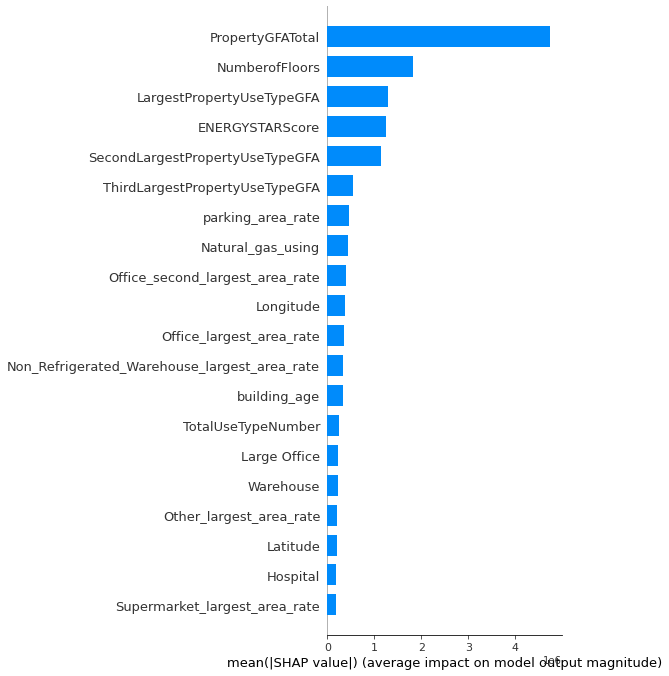

In [102]:
shap.summary_plot(shap_values, plot_type = 'bar', feature_names = data_to_model_energy_list)

In [103]:
#data.to_csv("data_modeling_P4.csv")